# Text Classification using FNet

**Author:** [Abheesht Sharma](https://github.com/abheesht17/)<br>
**Date created:** 2022/06/01<br>
**Last modified:** 2022/12/21<br>
**Description:** Text Classification on the IMDb Dataset using `keras_nlp.layers.FNetEncoder` layer.

## Introduction

In this example, we will demonstrate the ability of FNet to achieve comparable
results with a vanilla Transformer model on the text classification task.
We will be using the IMDb dataset, which is a
collection of movie reviews labelled either positive or negative (sentiment
analysis).

To build the tokenizer, model, etc., we will use components from
[KerasNLP](https://github.com/keras-team/keras-nlp). KerasNLP makes life easier
for people who want to build NLP pipelines! :)

### Model

Transformer-based language models (LMs) such as BERT, RoBERTa, XLNet, etc. have
demonstrated the effectiveness of the self-attention mechanism for computing
rich embeddings for input text. However, the self-attention mechanism is an
expensive operation, with a time complexity of `O(n^2)`, where `n` is the number
of tokens in the input. Hence, there has been an effort to reduce the time
complexity of the self-attention mechanism and improve performance without
sacrificing the quality of results.

In 2020, a paper titled
[FNet: Mixing Tokens with Fourier Transforms](https://arxiv.org/abs/2105.03824)
replaced the self-attention layer in BERT with a simple Fourier Transform layer
for "token mixing". This resulted in comparable accuracy and a speed-up during
training. In particular, a couple of points from the paper stand out:

* The authors claim that FNet is 80% faster than BERT on GPUs and 70% faster on
TPUs. The reason for this speed-up is two-fold: a) the Fourier Transform layer
is unparametrized, it does not have any parameters, and b) the authors use Fast
Fourier Transform (FFT); this reduces the time complexity from `O(n^2)`
(in the case of self-attention) to `O(n log n)`.
* FNet manages to achieve 92-97% of the accuracy of BERT on the GLUE benchmark.

## Setup

Before we start with the implementation, let's import all the necessary packages.

In [ ]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [4]:
# get pwd
!pwd
!mkdir -pv /mnt/beegfs/xchen87/keras-tutorial
# set pwd to /mnt/beegfs/xchen87/keras-tutorial
%cd /mnt/beegfs/xchen87/keras-tutorial
!pwd

/home/xchen87


/mnt/beegfs/xchen87/keras-tutorial
/mnt/beegfs/xchen87/keras-tutorial


In [1]:
import keras_nlp
import keras
import tensorflow as tf
import os

keras.utils.set_random_seed(42)

2024-03-08 07:42:37.781074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 07:42:37.781131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 07:42:37.853133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 07:42:38.025359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 07:42:44.968741: W tensorflow/compiler/tf2

Using TensorFlow backend


Let's also define our hyperparameters.

In [5]:
BATCH_SIZE = 64
EPOCHS = 3
MAX_SEQUENCE_LENGTH = 512
VOCAB_SIZE = 15000

EMBED_DIM = 128
INTERMEDIATE_DIM = 512

## Loading the dataset

First, let's download the IMDB dataset and extract it.

In [6]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2024-03-08 07:44:28--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M   370KB/s    in 3m 36s  

2024-03-08 07:48:04 (380 KB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Samples are present in the form of text files. Let's inspect the structure of
the directory.

In [7]:
print(os.listdir("./aclImdb"))
print(os.listdir("./aclImdb/train"))
print(os.listdir("./aclImdb/test"))

['imdb.vocab', 'imdbEr.txt', 'train', 'test', 'README']
['neg', 'unsup', 'urls_unsup.txt', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt']
['neg', 'pos', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt']


The directory contains two sub-directories: `train` and `test`. Each subdirectory
in turn contains two folders: `pos` and `neg` for positive and negative reviews,
respectively. Before we load the dataset, let's delete the `./aclImdb/train/unsup`
folder since it has unlabelled samples.

In [8]:
!rm -rf aclImdb/train/unsup

We'll use the `keras.utils.text_dataset_from_directory` utility to generate
our labelled `tf.data.Dataset` dataset from text files.

In [9]:
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
)
test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-03-08 07:51:10.946494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 07:51:11.059706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 07:51:11.061185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


We will now convert the text to lowercase.

In [10]:
train_ds = train_ds.map(lambda x, y: (tf.strings.lower(x), y))
val_ds = val_ds.map(lambda x, y: (tf.strings.lower(x), y))
test_ds = test_ds.map(lambda x, y: (tf.strings.lower(x), y))

Let's print a few samples.

In [12]:
for text_batch, label_batch in train_ds.take(1):
    print(text_batch.numpy().shape)
    print(label_batch.numpy().shape)
    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])


(64,)
(64,)
b"nobody said movies had to be realistic did they? i really liked this movie because i remember when i first saw it in junior high. for all the kids who remember the pmrc and albums before there were warning stickers, it's a cool story for all those kids who were part of the mid to late 80's headbanger crowd."
1
b"a different look at horror. the styling differences between american and russian films is interesting. however from my american perspective this movie just wasn't that good. the protagonist, marie played by anastasia hille wasn't a pleasant character and i had a hard time identifying with her. she was disagreeable most of the time and confused for much of what little time was left. also too much time was spent in bringing her to the main location of the film. then a long time passed before any real suspense built up. once that happened it seemed volume was used as the main effect which was more annoying than anything else. the concept was more original than most d

### Tokenizing the data

We'll be using the `keras_nlp.tokenizers.WordPieceTokenizer` layer to tokenize
the text. `keras_nlp.tokenizers.WordPieceTokenizer` takes a WordPiece vocabulary
and has functions for tokenizing the text, and detokenizing sequences of tokens.

Before we define the tokenizer, we first need to train it on the dataset
we have. The WordPiece tokenization algorithm is a subword tokenization algorithm;
training it on a corpus gives us a vocabulary of subwords. A subword tokenizer
is a compromise between word tokenizers (word tokenizers need very large
vocabularies for good coverage of input words), and character tokenizers
(characters don't really encode meaning like words do). Luckily, KerasNLP
makes it very simple to train WordPiece on a corpus with the
`keras_nlp.tokenizers.compute_word_piece_vocabulary` utility.

Note: The official implementation of FNet uses the SentencePiece Tokenizer.

In [13]:

def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab


Every vocabulary has a few special, reserved tokens. We have two such tokens:

- `"[PAD]"` - Padding token. Padding tokens are appended to the input sequence length
when the input sequence length is shorter than the maximum sequence length.
- `"[UNK]"` - Unknown token.

In [14]:
reserved_tokens = ["[PAD]", "[UNK]"]
train_sentences = [element[0] for element in train_ds]
vocab = train_word_piece(train_ds, VOCAB_SIZE, reserved_tokens)

Let's see some tokens!

In [15]:
print("Tokens: ", vocab[100:110])

Tokens:  ['à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é']


In [17]:
# print the top 10 longest tokens
sorted_vocab = sorted(vocab, key=lambda x: len(x), reverse=True)
print("Longest tokens: ", sorted_vocab[:10])
# print 10 in the middle
print("Middle tokens: ", sorted_vocab[5000:5010])

Longest tokens:  ['characterizations', 'characterization', 'incomprehensible', 'characterisation', 'enthusiastically', 'unintentionally', 'cinematographer', 'straightforward', 'characteristics', 'interpretations']
Middle tokens:  ['tonight', 'travels', 'yelling', 'designs', 'emperor', 'illegal', 'judging', 'montana', 'classes', 'directs']


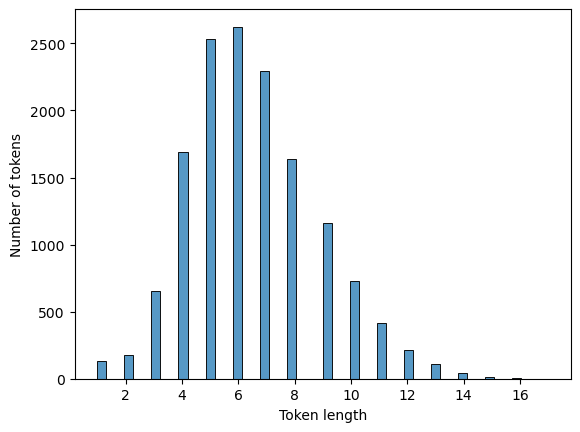

In [26]:
# plot histogram of token length
# use seaborn
import seaborn as sns
import matplotlib.pyplot as plt

token_lengths = [len(token) for token in vocab]
sns.histplot(token_lengths, bins=50)
plt.xlabel("Token length")
plt.ylabel("Number of tokens")
plt.show()

Now, let's define the tokenizer. We will configure the tokenizer with the
the vocabularies trained above. We will define a maximum sequence length so that
all sequences are padded to the same length, if the length of the sequence is
less than the specified sequence length. Otherwise, the sequence is truncated.

In [18]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=False,
    sequence_length=MAX_SEQUENCE_LENGTH,
)

Let's try and tokenize a sample from our dataset! To verify whether the text has
been tokenized correctly, we can also detokenize the list of tokens back to the
original text.

In [19]:
input_sentence_ex = train_ds.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))


Sentence:  tf.Tensor(b"prot\xc3\xa9g\xc3\xa9 runs in a linear fashion; expect no fast-paced action, and neither will you find yourself with baited breath because there are simply no seating-on-the-edge moments.<br /><br />there is not much of a crux, so don't expect one either. i would not fault the acting - the show would have been much worst if not for wu's acting which was the film's only saving grace. and, oh that cute little girl too.<br /><br />the humour is at best, weak, and the show must as well pass off as an anti-drug campaign which employs the usual shock-tactic (esp in the scenes with zhang) to tell us stuff that we already know - i.e. drugs break up families, heroin drives you crazy, it is not so easy to wean off, you will fall into a vicious cycle.<br /><br />i know it may seem all a little harsh, but i feel that the show is far from seamless and somewhat patchy (*spoiler alert*: take for example when andy lau got brought to the police station: what? we were just told 'o

In [28]:
len(input_tokens_ex)

512

## Formatting the dataset

Next, we'll format our datasets in the form that will be fed to the models. We
need to tokenize the text.

In [20]:

def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)


def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(512).prefetch(16).cache()


train_ds = make_dataset(train_ds)
val_ds = make_dataset(val_ds)
test_ds = make_dataset(test_ds)

## Building the model

Now, let's move on to the exciting part - defining our model!
We first need an embedding layer, i.e., a layer that maps every token in the input
sequence to a vector. This embedding layer can be initialised randomly. We also
need a positional embedding layer which encodes the word order in the sequence.
The convention is to add, i.e., sum, these two embeddings. KerasNLP has a
`keras_nlp.layers.TokenAndPositionEmbedding ` layer which does all of the above
steps for us.

Our FNet classification model consists of three `keras_nlp.layers.FNetEncoder`
layers with a `keras.layers.Dense` layer on top.

Note: For FNet, masking the padding tokens has a minimal effect on results. In the
official implementation, the padding tokens are not masked.

In [21]:
input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)


x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

fnet_classifier = keras.Model(input_ids, outputs, name="fnet_classifier")

## Training our model

We'll use accuracy to monitor training progress on the validation data. Let's
train our model for 3 epochs.

In [22]:
fnet_classifier.summary()
fnet_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
fnet_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "fnet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 128)         1985536   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 f_net_encoder (FNetEncoder  (None, None, 128)         132224    
 )                                                               
                                                                 
 f_net_encoder_1 (FNetEncod  (None, None, 128)         132224    
 er)                                                             
                                                                 
 f_net_encoder_2 (FNetEncod  (None, None, 128)     

2024-03-08 08:07:11.956936: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc3c45e8090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 08:07:11.956972: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-08 08:07:12.095855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-08 08:07:13.030724: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1709903233.151390 1792711 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 [==============================] - 39s 83ms/step - loss: 0.5070 - accuracy: 0.7163 - val_loss: 0.3341 - val_accuracy: 0.8532
Epoch 2/3
313/313 [==============================] - 6s 18ms/step - loss: 0.2480 - accuracy: 0.8998 - val_loss: 0.3671 - val_accuracy: 0.8518
Epoch 3/3
313/313 [==============================] - 6s 18ms/step - loss: 0.1564 - accuracy: 0.9413 - val_loss: 0.3660 - val_accuracy: 0.8634


We obtain a train accuracy of around 92% and a validation accuracy of around
85%. Moreover, for 3 epochs, it takes around 86 seconds to train the model
(on Colab with a 16 GB Tesla T4 GPU).

Let's calculate the test accuracy.

In [23]:
fnet_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)


391/391 [==============================] - 5s 6ms/step - loss: 0.3869 - accuracy: 0.8497


[0.386921763420105, 0.8497200012207031]

## Comparison with Transformer model

Let's compare our FNet Classifier model with a Transformer Classifier model. We
keep all the parameters/hyperparameters the same. For example, we use three
`TransformerEncoder` layers.

We set the number of heads to 2.

In [24]:
NUM_HEADS = 2
input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")


x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)


x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer_classifier = keras.Model(input_ids, outputs, name="transformer_classifier")


transformer_classifier.summary()
transformer_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
transformer_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 128)         1985536   
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_encoder (Trans  (None, None, 128)         198272    
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, None, 128)         198272    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, None, 12

We obtain a train accuracy of around 94% and a validation accuracy of around
86.5%. It takes around 146 seconds to train the model (on Colab with a 16 GB Tesla
T4 GPU).

Let's calculate the test accuracy.

In [25]:
transformer_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)

391/391 [==============================] - 5s 12ms/step - loss: 0.4395 - accuracy: 0.8517


[0.43950578570365906, 0.8516799807548523]

Let's make a table and compare the two models. We can see that FNet
significantly speeds up our run time (1.7x), with only a small sacrifice in
overall accuracy (drop of 0.75%).

|                         | **FNet Classifier** | **Transformer Classifier** |
|:-----------------------:|:-------------------:|:--------------------------:|
|    **Training Time**    |      86 seconds     |         146 seconds        |
|    **Train Accuracy**   |        92.34%       |           93.85%           |
| **Validation Accuracy** |        85.21%       |           86.42%           |
|    **Test Accuracy**    |        83.94%       |           84.69%           |
|       **#Params**       |      2,321,921      |          2,520,065         |